# 1. Modeling data preprocessing

In [1]:
import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

## Dataset overview

In [2]:
df_full = pd.read_parquet('../data/ml_dataset_full.parquet')

We start this exercise by examining what data we have for modeling.

In [3]:
df_full.shape

(53700, 1009)

We have 53700 observations in total, and each observation has 1009 attributes.

In [4]:
df_full.iloc[:, :500].columns

Index(['voltage_0', 'voltage_1', 'voltage_2', 'voltage_3', 'voltage_4',
       'voltage_5', 'voltage_6', 'voltage_7', 'voltage_8', 'voltage_9',
       ...
       'voltage_490', 'voltage_491', 'voltage_492', 'voltage_493',
       'voltage_494', 'voltage_495', 'voltage_496', 'voltage_497',
       'voltage_498', 'voltage_499'],
      dtype='object', length=500)

500 of these attributes describe one voltage cycle at 50Hz AC, with a sampling rate of 25kHz (resulting in 500 samples).

In [5]:
df_full.iloc[:, 500:1000].columns

Index(['current_0', 'current_1', 'current_2', 'current_3', 'current_4',
       'current_5', 'current_6', 'current_7', 'current_8', 'current_9',
       ...
       'current_490', 'current_491', 'current_492', 'current_493',
       'current_494', 'current_495', 'current_496', 'current_497',
       'current_498', 'current_499'],
      dtype='object', length=500)

Another 500 describe one current cycle at 50Hz AC, with a sampling rate of 25kHz (again, 500 samples).

In [6]:
df_full.iloc[:, 1000:1006].columns

Index(['sensor_0', 'sensor_1', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_5'], dtype='object')

Six attributes represent six different sensors that can measure data such as temperature, humidity and air pressure. We do not know what these data are, but it may not be relevant for our purposes at this stage.

In [7]:
df_full.iloc[:, 1006:].columns

Index(['device_id', 'timestamp', 'label'], dtype='object')

The remaining three attributes are the device ID, timestamp and label.

The labels have been generated manually by an expert, and they can take the values 1, 2, 3 or 4. 1 represents the expected state of an asset, whereas 2-4 represent anomalies or uncertainties. If the observation hasn't been labelled, the label is empty.

In [8]:
df_full.label.value_counts(dropna=False)

NaN    48330
1.0     2110
3.0     1110
4.0     1100
2.0     1050
Name: label, dtype: int64

## Missing data

We investigate the missing data for the voltage, current, sensors and labels separately. The device IDs and timestamps are not relevant for this exercise, as they will not be used in the modeling.

In [9]:
df_voltage, df_current, df_sensors = df_full.iloc[:, :500], df_full.iloc[:, 500:1000], df_full.iloc[:, 1000:1006]

### Voltage

In [10]:
df_voltage.isnull().sum(axis=1).sort_values()

0          0
35748      0
35749      0
35750      0
35751      0
        ... 
9747     500
17131    500
39000    500
10383    500
45952    500
Length: 53700, dtype: int64

In [11]:
df_voltage.isnull().sum(axis=1).value_counts()

0      53432
500      268
dtype: int64

We can observe that there are 268 rows where the voltage cycle is completely missing. In all other cases, the cycle is completely present. As the voltage cycle most likely is crucial information in power distribution asset monitoring, it is a good idea to drop the row where this information is missing.

We drop these rows and regenerate all the dataframes.

In [12]:
df_cleansed = df_full[df_voltage.isnull().sum(axis=1) != 500].reset_index(drop=True)

In [13]:
df_cleansed.shape

(53432, 1009)

In [14]:
df_voltage, df_current, df_sensors = df_cleansed.iloc[:, :500], df_cleansed.iloc[:, 500:1000], df_cleansed.iloc[:, 1000:1006]

### Current

In [15]:
df_current.isnull().sum(axis=1).sort_values()

0          0
35485      0
35486      0
35487      0
35488      0
        ... 
4388     500
27085    500
23401    500
51713    500
17100    500
Length: 53432, dtype: int64

In [16]:
df_current.isnull().sum(axis=1).value_counts()

0      52631
500      801
dtype: int64

In the case of the current cycle, we currently have 801 observations where the information is completely missing. With the same reasoning as previously, we drop these from the dataset.

In [17]:
df_cleansed = df_cleansed[df_current.isnull().sum(axis=1) != 500].reset_index(drop=True)

In [18]:
df_cleansed.shape

(52631, 1009)

### Sensor data

In [19]:
df_sensors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53432 entries, 0 to 53431
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   sensor_0  52898 non-null  float64
 1   sensor_1  50760 non-null  float64
 2   sensor_2  51831 non-null  float64
 3   sensor_3  52368 non-null  float64
 4   sensor_4  45410 non-null  float64
 5   sensor_5  48096 non-null  float64
dtypes: float64(6)
memory usage: 2.4 MB


The sensor data also seems to have its fair share of missing values. However, we are not certain which sensors, if any, are relevant for this exercise.

To get a quick understanding of what sensors to focus on, we can use boxplots to see what the relationship between the sensor data and the labels are.

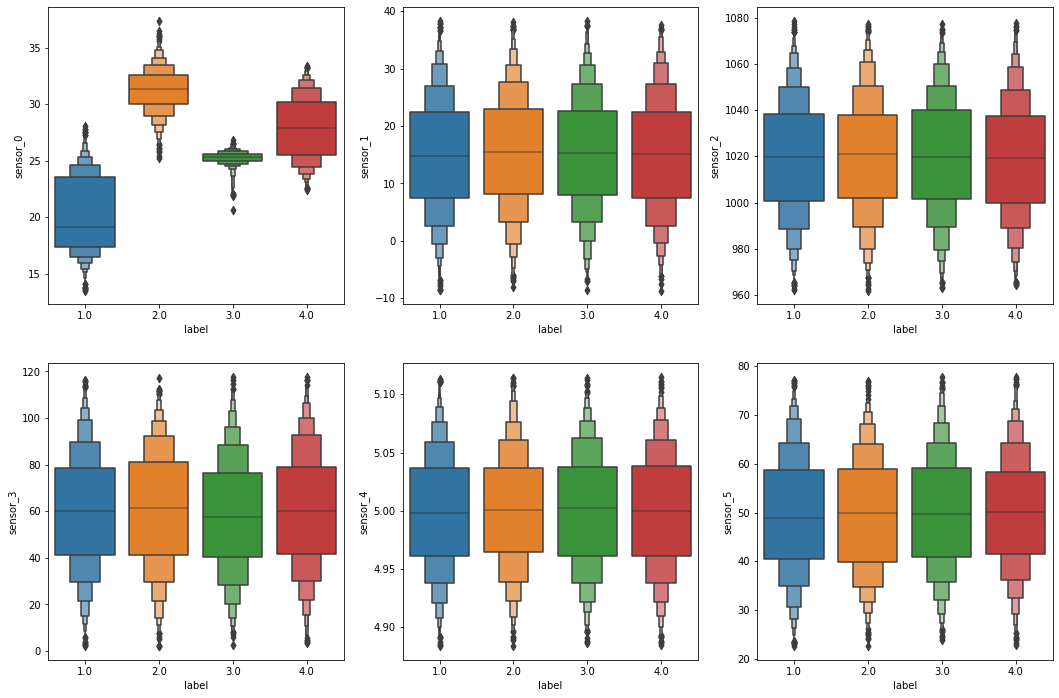

In [20]:
f = plt.figure(figsize=(18, 12))

dataframe = df_cleansed

ax1 = f.add_subplot(2, 3, 1)
ax1 = sns.boxenplot(x='label', y='sensor_0', data=dataframe)

ax2 = f.add_subplot(2, 3, 2)
ax2 = sns.boxenplot(x='label', y='sensor_1', data=dataframe)

ax3 = f.add_subplot(2, 3, 3)
ax3 = sns.boxenplot(x='label', y='sensor_2', data=dataframe)

ax4 = f.add_subplot(2, 3, 4)
ax4 = sns.boxenplot(x='label', y='sensor_3', data=dataframe)

ax5 = f.add_subplot(2, 3, 5)
ax5 = sns.boxenplot(x='label', y='sensor_4', data=dataframe)

ax6 = f.add_subplot(2, 3, 6)
ax6 = sns.boxenplot(x='label', y='sensor_5', data=dataframe)

plt.show()

Based on the figure above, sensors 1-5 do not seem to be very relevant in our case. However, sensor 0 definitely looks interesting. We therefore decide to only focus our efforts on sensor 0.

In [21]:
round(df_sensors.sensor_0.isna().sum() / df_sensors.sensor_0.count(), 3)

0.01

We could try to infer the missing data for sensor 0 using e.g. the mean, median or clustering, but 99% of the rows have data, we drop the rows with missing data to save some time.

In [22]:
df_cleansed = df_cleansed[~df_sensors.sensor_0.isna()].reset_index(drop=True)

<ipython-input-22-a2a3fb6430b5>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_cleansed = df_cleansed[~df_sensors.sensor_0.isna()].reset_index(drop=True)


In [23]:
df_cleansed.shape

(52102, 1009)

### Missing data - summary

We started out with 53700 observations. After cleansing the missing data, we ended up with 52102 observations.

## Preprocessing and feature engineering

To effectively work with the voltage and current data, we should align the cycles. We will do this by determining the highest point in the cycle, and shifting that to the beginning. To make sure that we don't tamper with the data, we carry out this shift based on the highest point of the voltage data.

In [27]:
df_voltage, df_current = df_cleansed.iloc[:, :500], df_cleansed.iloc[:, 500:1000]

for i in range(len(df_voltage)):
    shift = np.argmax(df_voltage.iloc[i])
    df_voltage.iloc[i] = np.roll(df_voltage.iloc[i], -shift)
    df_current.iloc[i] = np.roll(df_current.iloc[i], -shift)

df_cleansed.iloc[:, :500] = df_voltage
df_cleansed.iloc[:, 500:1000] = df_current

We then plot the voltage and current cycles based on the label to see if there are any patterns that we can directly observe.

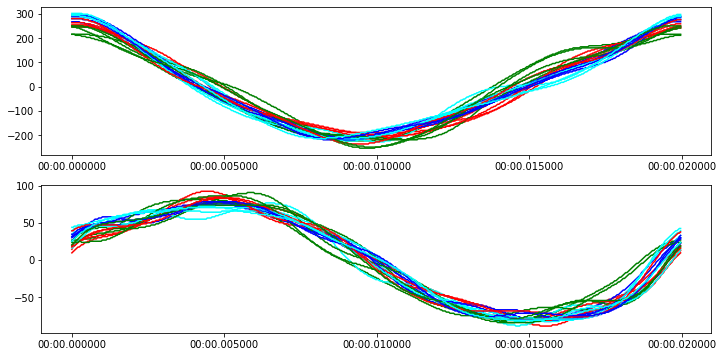

In [29]:
f = plt.figure(figsize=(12, 6))
ax1 = f.add_subplot(2, 1, 1)
ax2 = f.add_subplot(2, 1, 2)

r = 5
dataset = df_cleansed

for i in range(r):
    for label in [1, 2, 3, 4]:
        df_plot = dataset[dataset.label == label].reset_index(drop=True)
        voltage, current = df_plot.iloc[i, :500].astype(float), df_plot.iloc[i, 500:1000].astype(float)
        
        shift = np.argmax(voltage)
        voltage = np.roll(voltage, (-1) * shift)
        current = np.roll(current, (-1) * shift)
        
        start = datetime.datetime(2000, 1, 1)
        timestamp = np.arange(start, start + datetime.timedelta(microseconds=40 * 500), datetime.timedelta(microseconds=40))
        
        if label == 1:
            ax1.plot(timestamp, voltage, c='red')
            ax2.plot(timestamp, current, c='red')
        if label == 2:
            ax1.plot(timestamp, voltage, c='blue')
            ax2.plot(timestamp, current, c='blue')
        if label == 3:
            ax1.plot(timestamp, voltage, c='green')
            ax2.plot(timestamp, current, c='green')
        if label == 4:
            ax1.plot(timestamp, voltage, c='cyan')
            ax2.plot(timestamp, current, c='cyan')

plt.show()

We can see that, especially for the voltage, there are some general differences between the various labels.

### Fourier Transform

We apply the Fourier transform to the voltage and current.

In [164]:
df_voltage, df_current = df_cleansed.iloc[:, :500], df_cleansed.iloc[:, 500:1000]

features = 10
sampling_rate = 25000

voltage_cols = [f'voltage_fft_{i}' for i in range(features)]
current_cols = [f'current_fft_{i}' for i in range(features)]

voltage_ft = np.real(np.fft.fft(df_voltage))[:, :features] / sampling_rate
current_ft = np.real(np.fft.fft(df_current))[:, :features] / sampling_rate

df_voltage_ft = pd.DataFrame(voltage_ft, columns=voltage_cols)
df_current_ft = pd.DataFrame(current_ft, columns=current_cols)

In [170]:
df_ft = pd.concat([df_voltage_ft, df_current_ft, df_cleansed.iloc[:, 1000:]], axis=1)

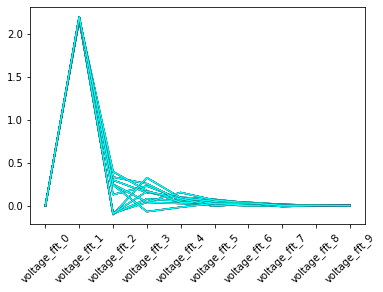

In [266]:
dataset = df_ft
r = 10

for i in range(r):
    for label in [1, 2, 3, 4]:
        spectrum = dataset.iloc[i, :10]
        if label == 1:
            plt.plot(spectrum, c='red')
        if label == 2:
            plt.plot(spectrum, c='blue')
        if label == 3:
            plt.plot(spectrum, c='green')
        if label == 4:
            plt.plot(spectrum, c='cyan')

plt.xticks(rotation=45)
plt.show()

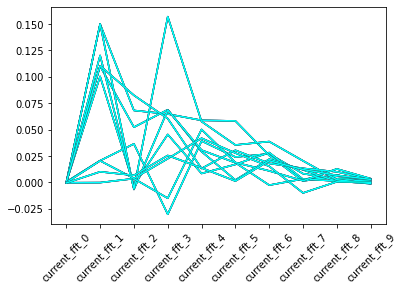

In [267]:
dataset = df_ft
r = 10

for i in range(r):
    for label in [1, 2, 3, 4]:
        spectrum = dataset.iloc[i, 10:20]
        if label == 1:
            plt.plot(spectrum, c='red')
        if label == 2:
            plt.plot(spectrum, c='blue')
        if label == 3:
            plt.plot(spectrum, c='green')
        if label == 4:
            plt.plot(spectrum, c='cyan')

plt.xticks(rotation=45)
plt.show()

The values tend to zero as the number of feature grows both in the case of the voltage and the current. Using 10 features going forward therefore seems reasonable.

## Exporting preprocessed data

We export the preprocessed data to a new parquet file.

In [281]:
df_ft.to_parquet('../data/ml_dataset_preprocessed.parquet', compression='gzip')